In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyomo.environ import *
from pyomo.network import *
from idaes.core.util.model_statistics import degrees_of_freedom
from Method import *
from Unit_Model import *

In [2]:
# Create a concrete model
m = ConcreteModel()

# Define a set for components
m.Phase = Set(initialize = ['Liq','Vap'])
m.Comp = Set(initialize = ['benzene','toluene','methane','hydrogen'])

# construct every unit operation
m.R101 = R101_creater(m)
m.H101 = H101_creater(m)
m.F101 = F101_creater(m)
m.F102 = F102_creater(m)
m.M101 = M101_creater(m)
m.S101 = S101_creater(m)

![](HDA_flowsheet.png) 

In [3]:
# Add the Arc to connect
m.s4 = Arc(source=m.H101.Outlet, destination=m.R101.Inlet)
m.s5 = Arc(source=m.R101.Outlet, destination=m.F101.Inlet)
m.s9 = Arc(source=m.F101.Liq_Outlet, destination=m.F102.Inlet)
m.s6 = Arc(source=m.F101.Vap_Outlet, destination=m.S101.Inlet)
m.s7 = Arc(source=m.S101.Recycle, destination=m.M101.Recycle_Feed)
m.s3 = Arc(source=m.M101.Outlet, destination=m.H101.Inlet)
TransformationFactory("network.expand_arcs").apply_to(m)

In [4]:
# Setting for heater
m.H101.outlet.P.fix(350000)
m.H101.outlet.T.fix(600)

# Setting for flash vessel
m.F101.outlet.P.fix(350000)
m.F101.outlet.T.fix(325)

m.F102.outlet.P.fix(150000)
m.F102.outlet.T.fix(375)

# Setting for reactor heat duty
m.R101.Q.fix(0)

In [5]:
# two inlet feeds set
m.M101.inlet_feed['Toluene'].flow['Liq','benzene'].fix(1e-8)
m.M101.inlet_feed['Toluene'].flow['Liq','toluene'].fix(0.30)
m.M101.inlet_feed['Toluene'].flow['Liq','methane'].fix(1e-8)
m.M101.inlet_feed['Toluene'].flow['Liq','hydrogen'].fix(1e-8)
m.M101.inlet_feed['Toluene'].flow['Vap','benzene'].fix(1e-8)
m.M101.inlet_feed['Toluene'].flow['Vap','toluene'].fix(1e-8)
m.M101.inlet_feed['Toluene'].flow['Vap','methane'].fix(1e-8)
m.M101.inlet_feed['Toluene'].flow['Vap','hydrogen'].fix(1e-8)
m.M101.inlet_feed['Toluene'].T.fix(303.2)
m.M101.inlet_feed['Toluene'].P.fix(350000)

m.M101.inlet_feed['Hydrogen'].flow['Liq','benzene'].fix(1e-8)
m.M101.inlet_feed['Hydrogen'].flow['Liq','toluene'].fix(1e-8)
m.M101.inlet_feed['Hydrogen'].flow['Liq','methane'].fix(1e-8)
m.M101.inlet_feed['Hydrogen'].flow['Liq','hydrogen'].fix(1e-8)
m.M101.inlet_feed['Hydrogen'].flow['Vap','benzene'].fix(1e-8)
m.M101.inlet_feed['Hydrogen'].flow['Vap','toluene'].fix(1e-8)
m.M101.inlet_feed['Hydrogen'].flow['Vap','methane'].fix(0.02)
m.M101.inlet_feed['Hydrogen'].flow['Vap','hydrogen'].fix(0.30)
m.M101.inlet_feed['Hydrogen'].T.fix(303.2)
m.M101.inlet_feed['Hydrogen'].P.fix(350000)

In [6]:
# Check the DOF of the whole model
degrees_of_freedom(m)

0

In [7]:
# set cooling cost for F101 & R101
m.cooling_cost = Expression(
    expr=0.212e-7 * (-m.F101.Q) + 0.212e-7 * (-m.R101.Q)
)

In [8]:
# set heating cost for H101 & F102
m.heating_cost = Expression(
    expr=2.2e-7 * m.H101.Q + 1.9e-7 * m.F102.Q
)

In [9]:
m.operating_cost = Expression(
    expr=(3600 * 8000 * (m.heating_cost + m.cooling_cost))
)

In [10]:
# Initialization with Sequential Decomposition method
seq = SequentialDecomposition()
seq.options.select_tear_method = "heuristic" 
seq.options.tear_method = "Wegstein"
seq.options.iterLim = 10

# which stream to tear / what's the calculation order
G = seq.create_graph(m)
heuristic_tear_set = seq.tear_set_arcs(G, method="heuristic")
order = seq.calculation_order(G)

In [11]:
for o in heuristic_tear_set:
    print("Tear Stream:",o.name)

Tear Stream: s4


In [12]:
cal_order = []
for o in order:
    cal_order.append(o[0].name)
print("Calculation Order:",cal_order)

Calculation Order: ['R101', 'F101', 'F102', 'M101', 'H101']


In [13]:
# Initialization function for each unit
def function(unit):
    if 'R' in unit.name:
        Initialize(unit,Arc=m.s4)
    elif 'F101' in unit.name:
        Initialize(unit,Arc=m.s5)
    elif 'F102' in unit.name:
        Initialize(unit,Arc=m.s9)
    elif 'S' in unit.name:
        Initialize(unit,Arc=m.s6)
    elif 'M' in unit.name:
        Initialize(unit,Arc=m.s7)
    elif 'H' in unit.name:
        Initialize(unit,Arc=m.s3)

In [14]:
# guess for tear stream (s1: H101 -> R101)
tear_guesses = {
    'flow': {
        ("Vap", "benzene"): 1e-5,
        ("Vap", "toluene"): 0.3,
        ("Vap", "hydrogen"): 0.30,
        ("Vap", "methane"): 0.02,
        ("Liq", "benzene"): 1e-5,
        ("Liq", "toluene"): 1e-5,
        ("Liq", "hydrogen"): 1e-5,
        ("Liq", "methane"): 1e-5,
    },
    'T': 600,
    'P': 350000,
}

# Pass the tear_guess to the SD tool
seq.set_guesses_for(m.R101.Inlet, tear_guesses)

In [15]:
seq.run(m,function)

Initialization complete for 'R101'! 
Initialization complete for 'F101'! 
model.name="F102";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
Initialization complete for 'F102'! 
Initialization complete for 'S101'! 
Initialization complete for 'M101'! 
Initialization complete for 'H101'! 
Initialization complete for 'R101'! 
Initialization complete for 'F101'! 
Initialization complete for 'S101'! 
Initialization complete for 'M101'! 
Initialization complete for 'H101'! 
Initialization complete for 'R101'! 
Initialization complete for 'F101'! 
Initialization complete for 'S101'! 
Initialization complete for 'M101'! 
Initialization complete for 'H101'! 
Initialization complete for 'R101'! 
Initialization complete for 'F101'! 
Initialization complete for 'S101'! 
Initialization complete for 'M101'! 
Initialization complete for 'H101'! 
Initialization complete for 'R101'! 
Initializ

In [16]:
degrees_of_freedom(m)

0

In [17]:
# 模型求解
solver = SolverFactory('ipopt')
solver.options['tol'] = 1e-4
results = solver.solve(m)
#results = solver.solve(m)

In [18]:
print("operating cost = $", value(m.operating_cost))

print()
print("Product flow rate and purity in F102")
for p in m.Phase:
    for c in m.Comp:
        print('\t [',p,',',c,']: ',value(m.F102.outlet.flow[p,c]))

print()
print("benzene purity = ", value(m.purity))

print()
print("Overhead loss in F101", )
for p in m.Phase:
    for c in m.Comp:
        print('\t [',p,',',c,']: ',value(m.F101.outlet.flow[p,c]))

operating cost = $ 384318.87799340446

Product flow rate and purity in F102
	 [ Liq , benzene ]:  0.05193292452806948
	 [ Liq , toluene ]:  0.028248209882799004
	 [ Liq , methane ]:  1.59529904482609e-06
	 [ Liq , hydrogen ]:  3.328792920914294e-08
	 [ Vap , benzene ]:  0.1528760358941503
	 [ Vap , toluene ]:  0.0344093189602969
	 [ Vap , methane ]:  0.001607822015417737
	 [ Vap , hydrogen ]:  0.00010042591065256723



AttributeError: 'ConcreteModel' object has no attribute 'purity'

In [19]:
print("operating cost = $", value(m.operating_cost))

operating cost = $ 384318.87799340446


In [20]:
m.objective = Objective(expr=m.operating_cost)

In [21]:
m.H101.Outlet.T.unfix()
m.R101.Q.unfix()
m.F101.Vap_Outlet.T.unfix()
m.F102.Vap_Outlet.T.unfix()

In [22]:
m.F102.Vap_Outlet.P.unfix()

In [23]:
m.H101.Outlet.T.setlb(500)
m.H101.Outlet.T.setub(600)

m.R101.Outlet.T.setlb(600)
m.R101.Outlet.T.setub(800)

m.F101.Vap_Outlet.T.setlb(298.0)
m.F101.Vap_Outlet.T.setub(450.0)
m.F102.Vap_Outlet.T.setlb(298.0)
m.F102.Vap_Outlet.T.setub(450.0)
m.F102.Vap_Outlet.P.setlb(115000)
m.F102.Vap_Outlet.P.setub(165000)

In [24]:
m.overhead_loss = Constraint(
    expr=m.S101.Purge.flow['Vap','benzene']/m.R101.Outlet.flow['Vap','benzene']<=0.05
)

In [32]:
value(m.S101.Purge.flow['Vap','benzene']/m.R101.Outlet.flow['Vap','benzene'])

0.05000000991257592

In [25]:
m.product_flow = Constraint(
    expr=m.F102.Vap_Outlet.flow["Vap", "benzene"] >= 0.15
)

In [26]:
m.purity = m.F102.outlet.flow['Vap','benzene']/sum(m.F102.outlet.flow['Vap',c] for c in m.Comp)
m.product_purity = Constraint(expr=m.purity >= 0.80)

In [27]:
results = solver.solve(m, tee=True)

Ipopt 3.13.2: tol=0.0001


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. 

In [28]:
print("operating cost = $", value(m.operating_cost))

print()
print("Product flow rate and purity in F102")
for p in m.Phase:
    for c in m.Comp:
        print('\t [',p,',',c,']: ',value(m.F102.outlet.flow[p,c]))

print()
print("benzene purity = ", value(m.purity))

print()
print("Overhead loss in F101", )
for p in m.Phase:
    for c in m.Comp:
        print('\t [',p,',',c,']: ',value(m.F101.outlet.flow[p,c]))

operating cost = $ 284116.3035121963

Product flow rate and purity in F102
	 [ Liq , benzene ]:  0.06503357074199978
	 [ Liq , toluene ]:  0.035921963573496994
	 [ Liq , methane ]:  2.185530006892592e-06
	 [ Liq , hydrogen ]:  4.143060353953594e-08
	 [ Vap , benzene ]:  0.14999999003701064
	 [ Vap , toluene ]:  0.03325268265493508
	 [ Vap , methane ]:  0.002087410346900943
	 [ Vap , hydrogen ]:  0.0001251648068191856

benzene purity =  0.8087768020121621

Overhead loss in F101
	 [ Liq , benzene ]:  0.21503355077901043
	 [ Liq , toluene ]:  0.06917463622843208
	 [ Liq , methane ]:  0.002089585876907835
	 [ Liq , hydrogen ]:  0.00012519623742272511
	 [ Vap , benzene ]:  0.07167786587332738
	 [ Vap , toluene ]:  0.007281729089459883
	 [ Vap , methane ]:  1.236397640383841
	 [ Vap , hydrogen ]:  0.352528929044507


In [29]:
print("Optimal Values")
print()

print("H101 outlet temperature = ", value(m.H101.Outlet.T), "K")

print()
print("R101 outlet temperature = ", value(m.R101.Outlet.T), "K")

print()
print("F101 outlet temperature = ", value(m.F101.Vap_Outlet.T), "K")

print()
print("F102 outlet temperature = ", value(m.F102.Vap_Outlet.T), "K")
print("F102 outlet pressure = ", value(m.F102.Vap_Outlet.P), "Pa")

Optimal Values

H101 outlet temperature =  500.0 K

R101 outlet temperature =  697.486695484181 K

F101 outlet temperature =  308.3442636224523 K

F102 outlet temperature =  365.5876719613391 K
F102 outlet pressure =  115000.0 Pa


Costs in $1000:


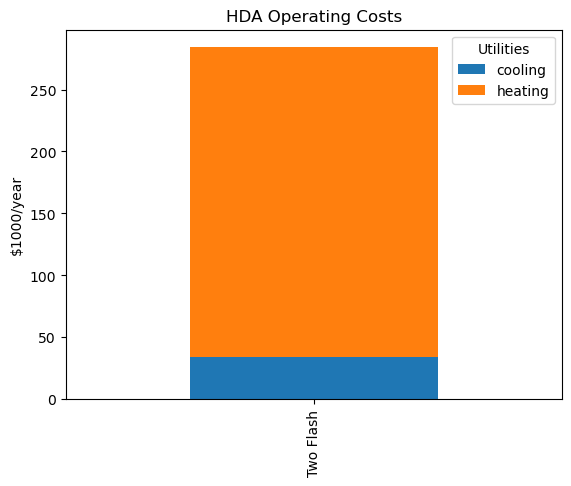

In [30]:
# Compare operating costs (per year)

operation_cost = {
    "cooling": value(3600 * 8000 * m.cooling_cost / 1e3),
    "heating": value(3600 * 8000 * m.heating_cost / 1e3),
}


hda_opdf = pd.DataFrame(
    list(operation_cost.items()), columns=["Utilities", "Two Flash"]
).set_index("Utilities")

opcosts = hda_opdf.transpose()

print("Costs in $1000:")
#display(opcosts)  # view dataframe before plotting

opplot = opcosts.plot(
    kind="bar", stacked=True, title="HDA Operating Costs", ylabel="$1000/year"
)

In [55]:
help(display)

Help on function display in module pyomo.core.base.misc:

display(obj, ostream=None)
    Display data in a Pyomo object



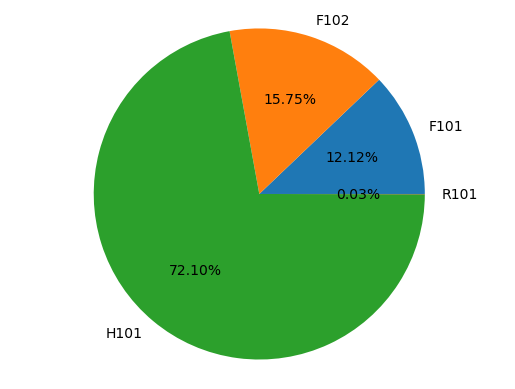

In [31]:
# 数据(优化前)
heat_duty = [abs(0.212e-7 * (-value(m.F101.Q))), abs(1.9e-7 * value(m.F102.Q)), 
             abs(2.2e-7 * value(m.H101.Q)), abs(0.212e-7 * (-value(m.R101.Q)))]
labels = [m.F101.name, m.F102.name, m.H101.name, m.R101.name]

# 饼状图
plt.pie(heat_duty, labels=labels, autopct='%1.2f%%')
plt.axis('equal')  # 保持长宽比相等
plt.show()

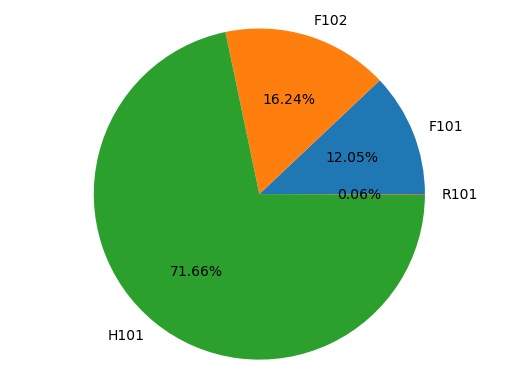

In [32]:
# 数据
heat_duty = [abs(0.212e-7 * (-value(m.F101.Q))), abs(1.9e-7 * value(m.F102.Q)), 
             abs(2.2e-7 * value(m.H101.Q)), abs(0.212e-7 * (-value(m.R101.Q)))]
labels = [m.F101.name, m.F102.name, m.H101.name, m.R101.name]

# 饼状图
plt.pie(heat_duty, labels=labels, autopct='%1.2f%%')
plt.axis('equal')  # 保持长宽比相等
plt.show()

In [9]:
# 创建一个示例DataFrame
data = {
    'A': [1, 2, 3],
    'B': [4, 5, 6],
    'C': [7, 8, 9]
}
df = pd.DataFrame(data)

print('原始DataFrame：')
print(df)

# 创建一个空的数据行
empty_row = pd.DataFrame([[None, None, None]], columns=['A', 'B', 'C'])

# 计算空行插入位置
middle_index = int(len(df) / 2)

# 使用concat方法将空行插入到DataFrame中间位置
df = pd.concat([df.iloc[:middle_index], empty_row, df.iloc[middle_index:]], ignore_index=True)

原始DataFrame：
   A  B  C
0  1  4  7
1  2  5  8
2  3  6  9


In [10]:
df

,A,B,C
0,1,4,7
1,None,None,None
2,2,5,8
3,3,6,9
